Accurate  output


In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load and clean dataset
df = pd.read_csv("Brand_data.csv")

# Combine features for model input
df["text"] = df["Feature"] + " [SEP] " + df["Brand"]

# Target: response (0 = negative, 1 = positive)
labels = df["Response"].tolist()

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), labels, test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset
class FeatureSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=64)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = FeatureSentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = FeatureSentimentDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Model
class SentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # binary classification
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(cls_output)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Train
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(8):
    model.train()
    train_loss, correct = 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = correct / len(val_dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} → Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")



c:\Users\mmomn\miniconda3\envs\fyp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


Epoch 1 → Train Loss: 0.1634, Train Acc: 0.9204, Val Loss: 0.0050, Val Acc: 1.0000


Epoch 2 Validation: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


Epoch 2 → Train Loss: 0.0032, Train Acc: 1.0000, Val Loss: 0.0014, Val Acc: 1.0000


Epoch 3 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


Epoch 3 → Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 1.0000


Epoch 4 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]


Epoch 4 → Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.0004, Val Acc: 1.0000


Epoch 5 Validation: 100%|██████████| 78/78 [00:32<00:00,  2.40it/s]


Epoch 5 → Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000


Epoch 6 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]


Epoch 6 → Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


Epoch 7 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


Epoch 7 → Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


Epoch 8 Validation: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]


Epoch 8 → Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


In [2]:
# Save model and tokenizer
model_path = "sentiment_model"
tokenizer_path = "tokenizer"

torch.save(model.state_dict(), f"{model_path}.pt")
tokenizer.save_pretrained(tokenizer_path)


('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json')

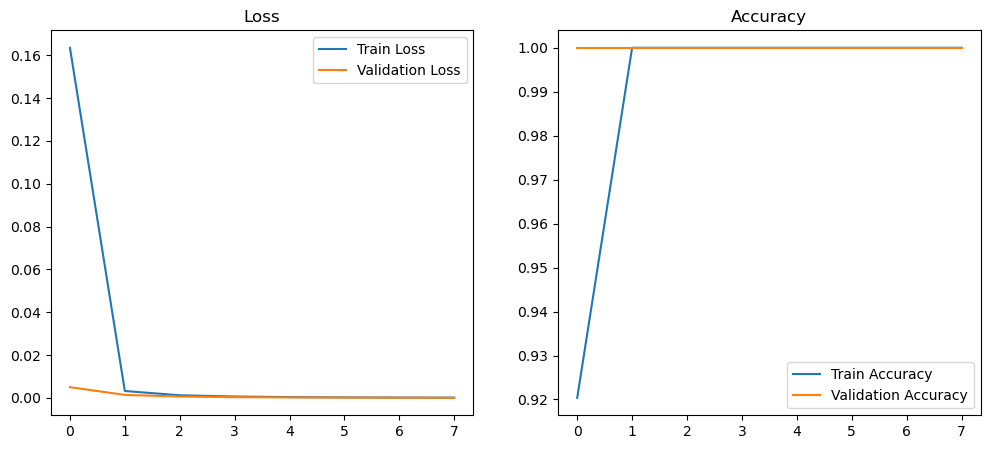

In [3]:

# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()


Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       265
    Positive       1.00      1.00      1.00       357

    accuracy                           1.00       622
   macro avg       1.00      1.00      1.00       622
weighted avg       1.00      1.00      1.00       622



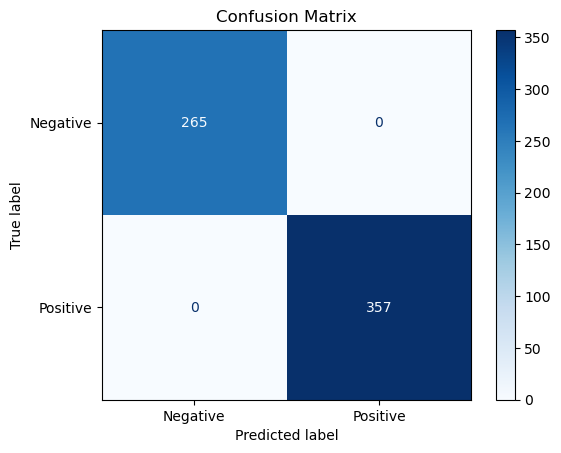

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


best function

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Brand_data.csv")

# Step 1: Get unique features in order
unique_features = df["Feature"].unique().tolist()

# Step 2: Map and display features
def display_features():
    print("Available features:")
    for idx, feat in enumerate(unique_features, start=1):
        print(f"{idx}. {feat}")

# Step 3: Get best brand per selected feature
def get_best_brand_per_feature(selected_indexes):
    best_brands = {}

    for idx in selected_indexes:
        if 1 <= idx <= len(unique_features):
            feature = unique_features[idx - 1]
            feature_df = df[df["Feature"] == feature]

            if idx % 2 == 1:  # positive feature → most 1s
                top_brand = feature_df[feature_df["Response"] == 1]["Brand"].value_counts().idxmax()
            else:  # negative feature → most 0s
                top_brand = feature_df[feature_df["Response"] == 0]["Brand"].value_counts().idxmax()

            best_brands[feature] = top_brand

    return best_brands

# Step 4: Get overall best brand across all features
def get_overall_best_brand():
    top_brand = df[df["Response"] == 1]["Brand"].value_counts().idxmax()
    return top_brand

# Step 5: Run everything together
def run_brand_analysis():
    display_features()
    user_input = input("\nEnter feature numbers (comma-separated, e.g. 1,3,5): ")

    try:
        selected_indexes = [int(i.strip()) for i in user_input.split(",") if i.strip().isdigit()]
    except:
        print("❌ Invalid input.")
        return

    best_brands = get_best_brand_per_feature(selected_indexes)
    overall_best = get_overall_best_brand()

    print("\n📌 Best brand for each selected feature:")
    for feat, brand in best_brands.items():
        print(f"   {feat}: {brand}")

    print(f"\n🏆 Overall best brand across all features: {overall_best}")

# Example usage:
# run_brand_analysis()


In [3]:
run_brand_analysis()

Available features:
1.  good _color _theme 
2. bad_color_theme
3. exceptional _fabric_ quality
4.  lowest_ fabric_ quality
5. current _fashion_ trends
6. not_current _fashion_ trends
7. durable and long_lasting collection
8. not_durable and long_lasting collection
9. strong _reputation 
10. low _reputation 
11. According_to_size
12. not_According_to_size
13.  Reasonable _Pricing 
14.  not_Reasonable _Pricing 
15.  good_ refund _and_ return policy
16.  bad_ refund _and_ return policy
17. easily_ accessible_ locations 
18. difficult_ accessible_ locations 
19.  maintain _color _after_ washing 
20. not_ maintain _color _after_ washing 
21. not_ allergic_ reaction 
22.  allergic_ reaction 
23. special_ features (like pockets,zips)
24. limited_special_ features (like pockets,zips)
25. high _quality_ materials
26. low _quality_ materials
27.  easy _to_ handle_fabric
28. difficult _to_ handle_fabric
29. excellent _customer _service 
30. bad _customer _service 

📌 Best brand for each selected 